In [124]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# Read in that data

In [3]:
df = pd.read_csv('data/no_dupes_lda_fit5_18.csv')

# 0. Are titles alone predictive?

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['listingTitle'], df['high_white'], random_state=0)

In [13]:
word_vectorizer = CountVectorizer()
word_vectorizer.fit(X_train)
X_train_vectorized = word_vectorizer.transform(X_train)
model = LogisticRegression(C=.1).fit(X_train_vectorized, y_train)
predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.7732740208879608
F1 score:  0.7181996086105675
accuracy:  0.6875508543531327


# Neighborhood names

In [15]:
with open('resources/hoods.txt', 'r') as inf:
    hoodnames = inf.read().splitlines()
    #hoodnames = inf.read()
    #hoodnames = re.split(r',\s*', hoodnames)

# Curated list of Seattle-area neighborhoods -- some manually added in.

In [47]:
neighbs = """"'Adams' 'Alki' 'Arbor Heights' 'Atlantic' 'Ballard' 'Belltown' 'Bellevue' Bitter Lake'
 'Bothell' 'Bremerton' 'Briarcliff' 'Brighton' 'Broadview' 'Broadway' 'Bryant' 'Capitol Hill' 'Cedar Park'
 'Central Business District' 'Columbia City' 'Crown Hill' 'Dunlap'
 'East Queen Anne' 'Eastlake' 'Everett' 'Fairmount Park' 'Fauntleroy' 'Federal Way' 'First Hill'
 'Fremont' 'Gatewood' 'Genesee' 'Georgetown' 'Green Lake' 'Greenlake' 'Greenwood'
 'Haller Lake' 'Harrison/Denny-Blaine' 'High Point' 'Highland Park'
 'Holly Park' 'Industrial District' 'Interbay' 'International District' 'Issaquah' 'Kirkland'
 'Laurelhurst' 'Lawton Park' 'Leschi' 'Lower Queen Anne' 'Loyal Heights'
 'Madison Park' 'Madrona' 'Mann' 'Maple Leaf' 'Matthews Beach'
 'Meadowbrook' 'Mid-Beacon Hill' 'Mill Creek' Minor' 'Montlake' 'Mount Baker' 'Newcastle'
 'North Admiral' 'North Beach/Blue Ridge' 'North Beacon Hill'
 'North College Park' 'North Delridge' 'North Queen Anne' 'Olympic Hills'
 'Phinney Ridge' 'Pike-Market' 'Pinehurst' 'Pioneer Square' 'Portage Bay'
 'Rainier Beach' 'Ravenna' 'Redmond' 'Renton' 'Riverview' 'Roosevelt' 'Roxhill' 'Seaview'
 'Seward Park' 'Shoreline' 'South Beacon Hill' 'South Delridge' 'South Lake Union'
 'South Park' 'Southeast Magnolia' 'Stevens' 'Sunset Hill'
 'University District' 'U District' 'UDistrict' 'Victory Heights' 'View Ridge' 'Wallingford'
 'Wedgwood' 'West Seattle' 'West Queen Anne' 'West Woodland' 'Westlake'
 'Whittier Heights' 'Windermere' 'Yesler Terrace'""".split("'")

In [48]:
hoods = [name.lower() for name in neighbs if re.match(r'\w+', name)]

In [5]:
hoods

['adams',
 'alki',
 'arbor heights',
 'atlantic',
 'ballard',
 'belltown',
 'bellevue',
 'bothell',
 'briarcliff',
 'brighton',
 'broadview',
 'broadway',
 'bryant',
 'capitol hill',
 'cedar park',
 'central business district',
 'columbia city',
 'crown hill',
 'dunlap',
 'east queen anne',
 'eastlake',
 'fairmount park',
 'fauntleroy',
 'federal way',
 'first hill',
 'fremont',
 'gatewood',
 'genesee',
 'georgetown',
 'green lake',
 'greenlake',
 'greenwood',
 'haller lake',
 'harrison/denny-blaine',
 'high point',
 'highland park',
 'holly park',
 'industrial district',
 'interbay',
 'international district',
 'issaquah',
 'kirkland',
 'laurelhurst',
 'lawton park',
 'leschi',
 'lower queen anne',
 'loyal heights',
 'madison park',
 'madrona',
 'mann',
 'maple leaf',
 'matthews beach',
 'meadowbrook',
 'mid-beacon hill',
 'mill creek',
 'montlake',
 'mount baker',
 'north admiral',
 'north beach/blue ridge',
 'north beacon hill',
 'north college park',
 'north delridge',
 'north quee

# Preprocess the data:
- Strip URLs (or.. should map them to '#url' ???)
- Map neighborhood names to '#hood'
- Tokenize words & punctuation


In [51]:
#url_pattern = r'(https?:\/\/)?(www)?.*[\r\n]*'


url_pattern = r'(http)?(www)?\S*(\.com|\.net|\.gov|\.be|\.org)\S*'

In [33]:
punctuation_pattern = r"[#\w'-]+|[.,!?;]+"

In [78]:
def preprocess(text):
    text = text.lower()
    no_urls = re.sub(url_pattern, '', text)
    for hood in hoodnames:
        # hood_pattern = r'\s+{0}\s+'.format(hood)
        #hood_pattern = r' ?'+hood+' ?'
        # Match neighborhood mentions surrounded by whitespace and replace with #hood
        no_urls = re.sub(r' {0} '.format(hood), ' #hood ', no_urls)
    no_digits = re.sub(r'\d+', '', no_urls)
    tokenized = re.findall(punctuation_pattern, no_digits)
    return ' '.join([word.lower() for word in tokenized])

In [79]:
short_example = "this queen anne apartment is really cool 98105 https://blah.com"

In [58]:
long_example = df.loc[0]['body_text']

In [59]:
clean = df.loc[0]['clean_text']

In [80]:
preprocess(short_example)

'this #hood apartment is really cool'

In [61]:
preprocess(long_example)

'property description enjoy this inviting #hood rambler just minutes from #hood square mall , lincoln square , and all the amenities #hood #hood has to offer . this home features hardwood floors , vaulted ceilings , and plenty of natural light . a spacious partially finished daylight basement features an additional living room , craft kitchen , and walk out to a full fenced yard . located in the acclaimed #hood school #hood and just a short walk to the #hood public library , this is the ideal home for everyone . pets are considered on a case by case basis . please contact adrian villanueva at show contact info or show contact info for more information . details availability date february 1 , 2017 pets cats , small dogs 25lb pet notes pets determined on a case by case basis deposit 3295 . 00 application fee 40 amenities laundry in unit parking type covered parking notes attached carport appliances dishwasher , refrigerator , microwave , range oven exterior yard-fenced , porch heating co

In [62]:
clean

'Property DescriptionEnjoy this inviting Bellevue rambler just minutes from Bellevue Square Mall Lincoln Square and all the amenities downtown Bellevue has to offer This home features hardwood floors vaulted ceilings and plenty of natural light A spacious partially finished daylight basement features an additional living room craft kitchen and walk out to a full fenced yardLocated in the acclaimed Bellevue school district and just a short walk to the Bellevue Public library this is the ideal home for everyonePets are considered on a case by case basis Please contact Adrian Villanueva atshow contact infoorshow contact infofor more informationDetailsAvailability dateFebruary PetsCats Small Dogs lbPet notesPets determined on a case by case basisDeposit $___ Application fee AmenitiesLaundryIn UnitParking typeCoveredParking notesAttached carportAppliancesDishwasher Refrigerator Microwave RangeOvenExteriorYardFenced PorchHeatingcoolingHeat forced air Double pane Storm windowsWiringCableready

In [35]:
texts = [[word for word in text.lower().split() if word not in hoodnames] for text in df.clean_text]

In [81]:
df['preproc_text'] = df['body_text'].apply(preprocess)

In [82]:
df['preproc_text'].to_string()

"0        property description enjoy this inviting #hood...\n1        contact info meridian green townhomes meridian...\n2        this spacious one bedroom apartment features c...\n3        welcome home to maple lane estates ! this unit...\n4        call us today show contact info fly on in ! se...\n5        contact info gerard leconte show contact info ...\n6        large apartment in duplex for rent in #hood . ...\n7        for rent a studio apartment in a turn of the c...\n8        new life . #hood beach . west #hood br ba for ...\n9        this rd floor unit faces north and east toward...\n10       br ba apartment in a brand new building july c...\n11       room available starting on march st , . i am r...\n12       contact info cydian show contact info show con...\n13       rent unit # in the lyric and i will pay you up...\n14       contact info mark show contact info totally re...\n15       sq ft charming studio in the heart of #hood . ...\n16       northgate plaza condominiums -

# Split the data into train & test sets

In [83]:
X_train, X_test, y_train, y_test = train_test_split(df['preproc_text'], df['high_white'], random_state=0)

In [84]:
word_vectorizer = CountVectorizer()

In [85]:
word_vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [86]:
word_vectorizer.get_feature_names()

['__',
 '____',
 '____________________',
 '_____________________',
 '__________________________',
 '___________________________',
 '____________________________',
 '_____________________________',
 '________________________________',
 '_________________________________',
 '___________________________________',
 '_____________________________________',
 '_______________________________________',
 '________________________________________',
 '_____________________________________________',
 '______________________________________________',
 '_______________________________________________',
 '________________________________________________',
 '_________________________________________________',
 '____________________________________________________________',
 '______________________________________________________________________',
 '___________________________________________________________________________',
 '___________________________________________________________________________

In [87]:
X_train_vectorized = word_vectorizer.transform(X_train)

In [88]:
# Logistic regression model
model = LogisticRegression(C=.1).fit(X_train_vectorized, y_train)

In [89]:
predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]

In [90]:
predictions

array([0.69689508, 0.50747233, 0.17848394, ..., 0.43929631, 0.95304177,
       0.97286799])

In [91]:
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

In [92]:
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.8573331166524223
F1 score:  0.8039738308698813
accuracy:  0.7805804176837537


In [93]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

(0.0, 1.0)

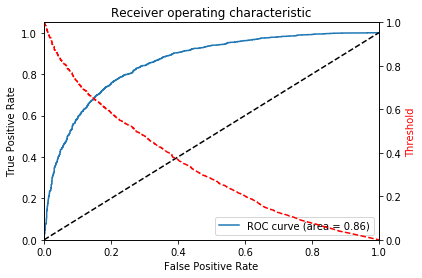

In [94]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

In [95]:
feature_names = np.array(word_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1]
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['westwood' 'moda' 'rianna' 'marymoor' 'riverpark' 'sculpture' 'concierge'
 'mall' 'stadiums' 'baker' 'fountain' 'harbor' 'airport' 'beacon' 'rail'
 'pools' 'aurora' 'bellevue' 'swedish' 'cleveland']

Largest Coefs: 
['zoo' 'pearl' 'woodland' 'cairns' 'inglenook' 'sweeping' 'foods'
 'ballard' 'pinnacle' 'springline' 'esxpt' 'urbana' 'ivorywood' 'locks'
 'northshore' 'harvard' 'volunteer' 'waterscape' 'beach' 'nw']


In [26]:
# lol. still too many neighborhood names... why aren't they getting stripped out???
# another (unrelated) idea: map words to word2vec on general domain pretrained vectors? lol

# Using ngram features

In [96]:
ngram_vectorizer = CountVectorizer(ngram_range=(1,4)).fit(X_train)

In [97]:
ngram_vectorizer.get_feature_names()

['__',
 '__ charm',
 '__ charm close',
 '__ charm close to',
 '__ cozy',
 '__ cozy studio',
 '__ cozy studio with',
 '__ electric',
 '__ electric baseboard',
 '__ electric baseboard heat',
 '__ large',
 '__ large closets',
 '__ large closets and',
 '__ nice',
 '__ nice and',
 '__ nice and bright',
 '__ parking',
 '__ parking available',
 '__ parking available fourplex',
 '__ walking',
 '__ walking distance',
 '__ walking distance to',
 '____',
 '____ screening',
 '____ screening fee',
 '____ screening fee for',
 '____________________',
 '____________________ rent',
 '____________________ rent month',
 '____________________ rent month for',
 '_____________________',
 '_____________________ no',
 '_____________________ no smoking',
 '_____________________ no smoking or',
 '_____________________ viewings',
 '_____________________ viewings by',
 '_____________________ viewings by appointment',
 '__________________________',
 '__________________________ one',
 '__________________________ on

In [103]:
X_train_ngrams = ngram_vectorizer.transform(X_train)
# Logistic regression model
model = LogisticRegression(C=.1).fit(X_train_ngrams, y_train)
predictions = model.predict_proba(ngram_vectorizer.transform(X_test))[:,1]

In [104]:
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

In [105]:
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.8848347877248681
F1 score:  0.8306801736613604
accuracy:  0.8096013018714402


In [106]:
feature_names = np.array(ngram_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1]
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['mall' 'airport' 'pool' 'rail' 'south' 'shopping' 'hood university'
 'major' 'center' 'concierge' 'light rail' 'westwood' 'hood mall'
 'marymoor' 'club' 'harbor steps' 'gym' 'hood market' 'marymoor park'
 'moda']

Largest Coefs: 
['bars' 'hour fitness center' 'whole' 'locks' 'in home' 'hour fitness'
 'island square' 'whole foods' 'basement' 'st' 'hood ave' 'hill' 'deck'
 'hood village' 'shops' 'laundry' 'west' 'on hood' 'nw' 'beach']


In [43]:
# AP note (04/14) The neighborhood names are still not complete enough -_-
# also they are still sneaking in somehow... need more work on preproc
# 'kirkland' and 'issaquah' are IN the damn hoods list.. why are they still showing up?!

In [107]:
df.columns.values

array(['Unnamed: 0', 'listingTitle', 'listingDate', 'listingText',
       'listingMonth', 'listingYear', 'listingMoYr', 'price', 'cleanRent',
       'cleanBeds', 'cleanBaths', 'cleanSqft', 'postid', 'postOrigin',
       'matchType', 'address', 'matchAddress2', 'latitude', 'longitude',
       'catBeds', 'catBaths', 'catSqft', 'GEOID10', 'blockid', 'seattle',
       'total_RE', 'white', 'black', 'aindian', 'asian', 'pacisland',
       'other', 'latinx', 'total_poverty', 'under_poverty', 'income',
       'county', 'state', 'tract', 'acs_year', 'body_text', 'clean_text',
       'poverty_proportion', 'white_proportion', 'black_proportion',
       'aindian_proportion', 'asian_proportion', 'pacisland_proportion',
       'other_proportion', 'latinx_proportion', 'high_income',
       'high_poverty', 'high_white', 'high_black', 'high_aindian',
       'high_asian', 'high_pacisland', 'high_other', 'high_latinx',
       'log_income', 'clean_price', 'log_price', 'top_topic', '0', '1',
       '2', '3

In [108]:
# OK, that was a binary prediction on high-white; let's see high-black

In [109]:
# Prob a faster way to just grab new labels...
X_train, X_test, y_train, y_test = train_test_split(df['preproc_text'], df['high_black'], random_state=0)

In [110]:
X_train_ngrams = ngram_vectorizer.transform(X_train)
# Logistic regression model
model = LogisticRegression(C=.1).fit(X_train_ngrams, y_train)
predictions = model.predict_proba(ngram_vectorizer.transform(X_test))[:,1]

In [111]:
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

In [112]:
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.8796778871113075
F1 score:  0.7495016611295682
accuracy:  0.795497694602658


In [113]:
feature_names = np.array(ngram_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1]
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['nw' 'ne' 'hood square' 'uw' 'trails' 'square' 'school hood' 'island'
 'se' 'shops' 'newport' 'beach' 'ne hood' 'ave nw' 'courtyard' 'trail'
 'town center' 'mountains' 'facing' 'around']

Largest Coefs: 
['west hood' 'ave hood' 'apartment homes' 'station' 'city' 'pointe'
 'harbor' 'valley' 'concierge' 'golf' 'seattle' 'hood market' 'south hood'
 'th ave hood wa' 'light rail' 'th ave hood' 'airport' 'hood university'
 'hood hill' 'rail']


In [114]:
X_train_vectorized = word_vectorizer.transform(X_train)
model = LogisticRegression(C=.1).fit(X_train_vectorized, y_train)
predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.8406573537572876
F1 score:  0.7181789034947098
accuracy:  0.7615947925142392


In [115]:
feature_names = np.array(word_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1]
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['nw' 'ne' 'se' 'newport' 'springline' 'zoo' 'riverpark' 'marymoor'
 'urbana' 'tableau' 'finn' 'surrey' 'bear' 'costco' 'trails' 'ballard'
 'mercer' 'kirkland' 'fremont' 'lea']

Largest Coefs: 
['stadiums' 'taylor' 'pearl' 'centennial' 'aurora' 'hills' 'concierge'
 'valley' 'interurban' 'cityline' 'olympus' 'southcenter' 'airport'
 'pointe' 'olive' 'rianna' 'moda' 'westwood' 'harbor' 'rail']


In [118]:
y_test.value_counts()


0    2060
1    1627
Name: high_black, dtype: int64

In [119]:
1627/2060

0.7898058252427185

In [130]:
# Try SVM..

model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
model.fit(X_train_vectorized,y_train)
predicted = model.predict(word_vectorizer.transform(X_test))
np.mean(predicted == y_test)

0.6767019256848387

In [132]:
model.score(word_vectorizer.transform(X_test), y_test)

0.6767019256848387